# Generative Adversarial Networks - Monet exercise

In this exercise, I'm going to create a Generative Adversarial Network (GAN) for the Kaggle contest "I’m Something of a Painter Myself"

https://www.kaggle.com/competitions/gan-getting-started/overview

As part of this project I create a GitHub repository:

https://github.com/edmon2017/Use-GANs-to-create-art

The goal of this project is to create a GAN model which can generate images in the style of Monet, this model has two parts: a generator model and a discriminator model, where the generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

As final result, the GAN is going to generate 7,000 to 10,000 Monet-style images.


## Data loading
The data is in two folders, 'monet_jpg' cotains images from Monet paintings, and 'photo_jpg' contain images from photographs. The first step is to load the data from these folders

In [16]:
import os
import itertools
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid, save_image
import time

In [7]:
# Hyperparameters
DATA_ROOT       = '.'            
BATCH_SIZE      = 4
IMG_SIZE        = 256
NUM_EPOCHS      = 100
LR              = 2e-4
LAMBDA_CYCLE    = 10.0
LAMBDA_ID       = 5.0
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data loaders
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE+30),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

In [8]:
monet_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, 'monet_jpg'), transform=transform)
photo_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, 'photo_jpg'), transform=transform)
monet_loader = DataLoader(monet_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
photo_loader = DataLoader(photo_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## Exploratory Data Analysis 

After loading the data, I'm going to analyze the content of each folder: how many files are and how it looks the data

In [9]:
print(f"Number of Monet images: {len(monet_ds)}")
print(f"Number of Photo images: {len(photo_ds)}")

Number of Monet images: 300
Number of Photo images: 7038


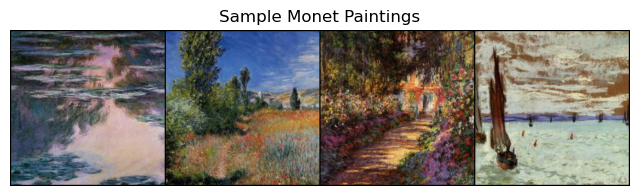

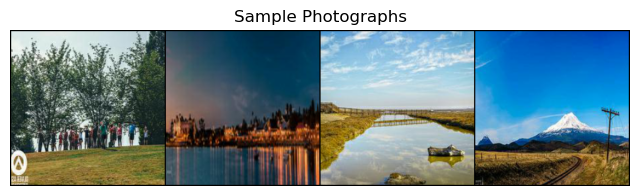

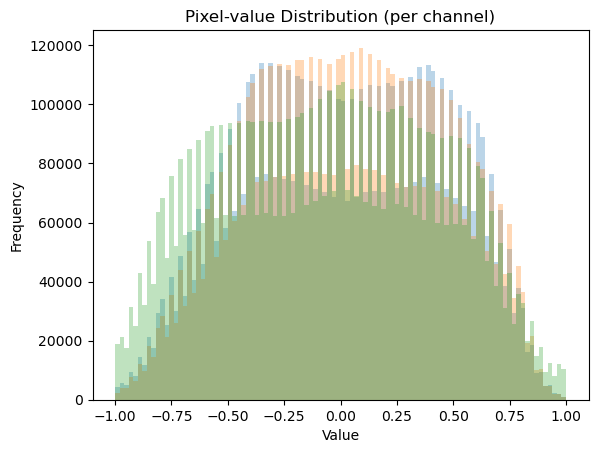

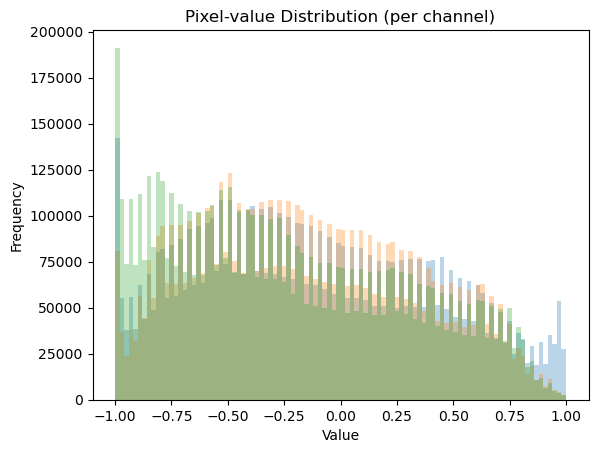

Unique original image sizes: {(256, 256)}


In [17]:
def show_batch(dl, title):
    imgs, _ = next(iter(dl))
    grid  = make_grid((imgs * 0.5 + 0.5), nrow=4)  # unnormalize to [0,1]
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(npimg)
    plt.axis('off')
    plt.title(title)
    plt.show()

show_batch(monet_loader, "Sample Monet Paintings")
show_batch(photo_loader, "Sample Photographs")

# Pixel-value distribution
def plot_pixel_histogram(ds, n_samples=100):
    all_pixels = []
    for i in range(n_samples):
        img, _ = ds[i]
        all_pixels.append(img.view(3, -1).cpu().numpy())
    all_pixels = np.concatenate(all_pixels, axis=1)
    plt.figure()
    for ch in range(3):
        channel = all_pixels[ch]
        plt.hist(channel, bins=100, alpha=0.3)
    plt.title("Pixel-value Distribution (per channel)")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

plot_pixel_histogram(monet_ds)
plot_pixel_histogram(photo_ds)

# Verify image sizes
sizes = [Image.open(path).size for path, _ in monet_ds.samples + photo_ds.samples]
unique_sizes = set(sizes)
print("Unique original image sizes:", unique_sizes)

## Analysis - Model building and training

In this exercise I'm goint to use a CycleGAN model with this charateristics:

* It has two Generators G: X→Y and F: Y→X

* It has two Discriminators Dₓ and Dᵧ to classify real vs. generated images in each domain

* The Loss components are:

    Adversarial loss for both G and F

    Cycle‐consistency loss, which ensures F(G(X))≈X and G(F(Y))≈Y

    Identity loss to preserve colour when passing images through the “wrong” generator

* Training flow: alternate updates of generators and discriminators, balancing adversarial and cycle losses



For Optimization I'm going to use Adam, and the discrimatores are optimized separately


### Model building

In [7]:
# Model definitions
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
        )
    def forward(self, x): return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, n_res=9):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True),
        ]
        # downsampling
        curr_dim = 64
        for _ in range(2):
            layers += [
                nn.Conv2d(curr_dim, curr_dim*2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(curr_dim*2),
                nn.ReLU(True),
            ]
            curr_dim *= 2
        # residual blocks
        for _ in range(n_res):
            layers += [ResidualBlock(curr_dim)]
        # upsampling
        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(curr_dim, curr_dim//2, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(curr_dim//2),
                nn.ReLU(True),
            ]
            curr_dim //= 2
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_ch, 7),
            nn.Tanh(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x): return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
        ]
        curr_dim = 64
        for mult in [2,4,8]:
            layers += [
                nn.Conv2d(curr_dim, curr_dim*mult, 4, stride=2 if mult<8 else 1, padding=1),
                nn.InstanceNorm2d(curr_dim*mult),
                nn.LeakyReLU(0.2, True),
            ]
            curr_dim *= mult
        layers += [nn.Conv2d(curr_dim, 1, 4, padding=1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x): return self.model(x)

# Instantiate
G  = Generator().to(DEVICE)  # X→Y (photo→monet)
F  = Generator().to(DEVICE)  # Y→X (monet→photo)
Dx = Discriminator().to(DEVICE)
Dy = Discriminator().to(DEVICE)

In [8]:
# Losses & optimizers
criterion_GAN      = nn.MSELoss()
criterion_cycle    = nn.L1Loss()
criterion_identity = nn.L1Loss()

opt_G = optim.Adam(itertools.chain(G.parameters(), F.parameters()),
                   lr=LR, betas=(0.5, 0.999))
opt_Dx = optim.Adam(Dx.parameters(), lr=LR, betas=(0.5, 0.999))
opt_Dy = optim.Adam(Dy.parameters(), lr=LR, betas=(0.5, 0.999))

# Buffers for previously generated images (for stable GAN training)
from collections import deque
fake_X_buffer = deque(maxlen=50)
fake_Y_buffer = deque(maxlen=50)

In [9]:
NUM_EPOCHS = 10

### Training

In [10]:
# Training loop
for epoch in range(1, NUM_EPOCHS+1):
    start = time.time()
    for (real_x, _), (real_y, _) in zip(photo_loader, monet_loader):
        real_x, real_y = real_x.to(DEVICE), real_y.to(DEVICE)
        batch_size = real_x.size(0)
        valid = torch.ones(batch_size, 1, 30, 30, device=DEVICE)
        fake  = torch.zeros_like(valid)

        # 5.1 Train Generators G and F
        opt_G.zero_grad()

        # Identity loss
        idt_y = G(real_y)
        loss_idt_y = criterion_identity(idt_y, real_y) * LAMBDA_ID
        idt_x = F(real_x)
        loss_idt_x = criterion_identity(idt_x, real_x) * LAMBDA_ID

        # GAN loss
        fake_y = G(real_x)
        pred_fake_y = Dy(fake_y)
        loss_GAN_xy = criterion_GAN(pred_fake_y, valid)

        fake_x = F(real_y)
        pred_fake_x = Dx(fake_x)
        loss_GAN_yx = criterion_GAN(pred_fake_x, valid)

        # Cycle loss
        recov_x = F(fake_y)
        loss_cycle_x = criterion_cycle(recov_x, real_x) * LAMBDA_CYCLE
        recov_y = G(fake_x)
        loss_cycle_y = criterion_cycle(recov_y, real_y) * LAMBDA_CYCLE

        # Total generator loss
        loss_G = loss_GAN_xy + loss_GAN_yx + loss_cycle_x + loss_cycle_y + loss_idt_x + loss_idt_y
        loss_G.backward()
        opt_G.step()

        # 5.2 Train Discriminator Dx
        opt_Dx.zero_grad()
        pred_real_x = Dx(real_x)
        loss_Dx_real = criterion_GAN(pred_real_x, valid)
        fake_X_buffer.append(fake_x.detach()) # Append to the buffer
        pred_fake_x = Dx(fake_X_buffer[-1])   # Access the last element of the buffer
        loss_Dx_fake = criterion_GAN(pred_fake_x, fake)
        (loss_Dx_real + loss_Dx_fake).backward()
        opt_Dx.step()

        # 5.3 Train Discriminator Dy
        opt_Dy.zero_grad()
        pred_real_y = Dy(real_y)
        loss_Dy_real = criterion_GAN(pred_real_y, valid)
        fake_Y_buffer.append(fake_y.detach()) # Append to the buffer
        pred_fake_y = Dy(fake_Y_buffer[-1])   # Access the last element of the buffer
        loss_Dy_fake = criterion_GAN(pred_fake_y, fake)
        (loss_Dy_real + loss_Dy_fake).backward()
        opt_Dy.step()

    # The print statement should be indented to match the for loop
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]  "
          f"G_loss: {loss_G.item():.4f}  "
          f"D_x: {(loss_Dx_real+loss_Dx_fake).item():.4f}  "
          f"D_y: {(loss_Dy_real+loss_Dy_fake).item():.4f}"
          f"Time: {time.time() - start:.2f}s")

Epoch [1/10]  G_loss: 10.9232  D_x: 0.5954  D_y: 0.5330Time: 301.36s
Epoch [2/10]  G_loss: 16.9556  D_x: 9.3821  D_y: 0.5005Time: 300.82s
Epoch [3/10]  G_loss: 10.7129  D_x: 0.4860  D_y: 0.5104Time: 300.84s
Epoch [4/10]  G_loss: 9.3571  D_x: 3.3148  D_y: 0.5335Time: 300.69s
Epoch [5/10]  G_loss: 7.7101  D_x: 0.4517  D_y: 0.5191Time: 300.75s
Epoch [6/10]  G_loss: 7.2605  D_x: 0.4680  D_y: 0.4716Time: 299.69s
Epoch [7/10]  G_loss: 8.5719  D_x: 0.6667  D_y: 0.8451Time: 300.63s
Epoch [8/10]  G_loss: 6.6488  D_x: 0.8329  D_y: 0.4744Time: 300.77s
Epoch [9/10]  G_loss: 6.8820  D_x: 0.5766  D_y: 0.5729Time: 300.45s
Epoch [10/10]  G_loss: 6.7401  D_x: 0.5473  D_y: 0.6357Time: 299.73s


## Results

For the result, I generate 7000 images with Mone style, and a ZIP file to compress the data

In [ ]:
# Generate and save outputs
os.makedirs('output1', exist_ok=True)
counter = 0
with torch.no_grad():
    for imgs, _ in photo_loader:
        imgs = imgs.to(DEVICE)
        fake_imgs = G(imgs)
        for img in fake_imgs:
            counter += 1
            save_image(
                (img * 0.5 + 0.5),  # unnormalize to [0,1]
                f'output/{counter:05d}.jpg'
            )

In [ ]:
# Zip results
with zipfile.ZipFile('images.zip', 'w') as zipf:
    for fname in sorted(os.listdir('output')):
        zipf.write(os.path.join('output', fname), arcname=fname)

print("Done! Generated images.zip")

## Conclusion

* In this project, I use a GAN model to create images using the Monet style, the approach was to use a CycleGAN model.
* The initial results are good, however the main limitation is the training time, because of the I had to reduce the number of epochs
* A future improvement could be increase the number of epochs a change some hyperparameters